<a href="https://colab.research.google.com/github/ItshMoh/Audio_Detection/blob/main/audioproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 42.7 MB/s eta 0:00:00


In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

In [ ]:
import os
import tensorflow_io as tfio
import tensorflow as tf


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
Parsed_Capuchinbird_file= os.path.join('/content/drive/MyDrive/Parsed_Capuchinbird_Clips/XC114131-1.wav')
not_Parsed_Capuchinbird_file= os.path.join('/content/drive/MyDrive/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-1.wav')

In [ ]:
def load_wav_16k_mono(foldername):
  file_contents= tf.io.read_file(foldername)
  wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)
  wav=tf.squeeze(wav,axis=-1)
  sample_rate=tf.cast(sample_rate,dtype=tf.int64)
  wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
  return wav

In [ ]:
wave=load_wav_16k_mono(Parsed_Capuchinbird_file)
nwave=load_wav_16k_mono(not_Parsed_Capuchinbird_file)

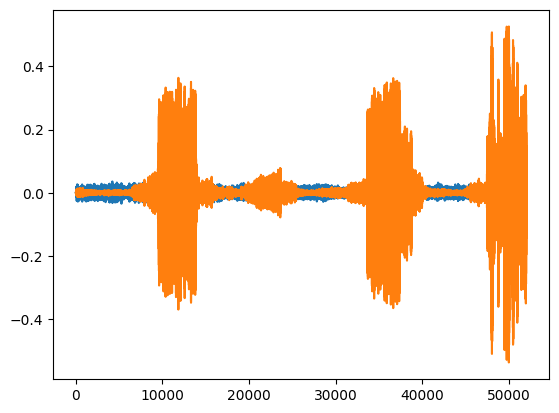

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
pos = os.path.join('/content/drive/My Drive/Parsed_Capuchinbird_Clips')
neg= os.path.join('/content/drive/My Drive/Parsed_Not_Capuchinbird_Clips')

In [ ]:
len(neg)

53

In [ ]:
pos=tf.data.Dataset.list_files(pos+'/*.wav')
neg=tf.data.Dataset.list_files(neg+'/*.wav')

In [ ]:
pos.as_numpy_iterator().next()

b'/content/drive/My Drive/Parsed_Capuchinbird_Clips/XC65196-1.wav'

In [ ]:
positives=tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives=tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [ ]:
data=positives.concatenate(negatives)

In [ ]:
lengths=[]
for file in os.listdir(os.path.join('/content/drive/MyDrive/Parsed_Capuchinbird_Clips')):
  tensor_wave= load_wav_16k_mono(os.path.join('/content/drive/MyDrive/Parsed_Capuchinbird_Clips',file))
  lengths.append(len(tensor_wave))

In [ ]:
lengths

In [ ]:
#It will show the maximum length of the calls of our dataset
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [ ]:
#It will show the average length of the calls of our data.
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
#It will show the minimum length of the calls of our data.
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
def preprocess(filepath,label):
  wav=load_wav_16k_mono(filepath)
  wav=wav[:48000]
  zero_padding= tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
  wav=tf.concat([zero_padding,wav],0)
  spectrogram= tf.signal.stft(wav,frame_length=320,frame_step=32)
  spectrogram=tf.abs(spectrogram)
  spectrogram=tf.expand_dims(spectrogram,axis=2)
  return spectrogram,label

In [ ]:
wav=load_wav_16k_mono(Parsed_Capuchinbird_file)
wav=wav[:48000]
zero_padding= tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
wav=tf.concat([zero_padding,wav],0)
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([-2.38103937e-08, -1.19024826e-08, -6.48144649e-08, ...,
       -5.84699772e-03,  6.84118923e-03, -6.73171133e-03], dtype=float32)>

In [ ]:
spectrogram= tf.signal.stft(wav,frame_length=320,frame_step=32)
spectrogram=tf.abs(spectrogram)
spectrogram=tf.expand_dims(spectrogram,axis=2)
spectrogram

In [ ]:
filepath , label= negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram,label=preprocess(filepath,label)
spectrogram

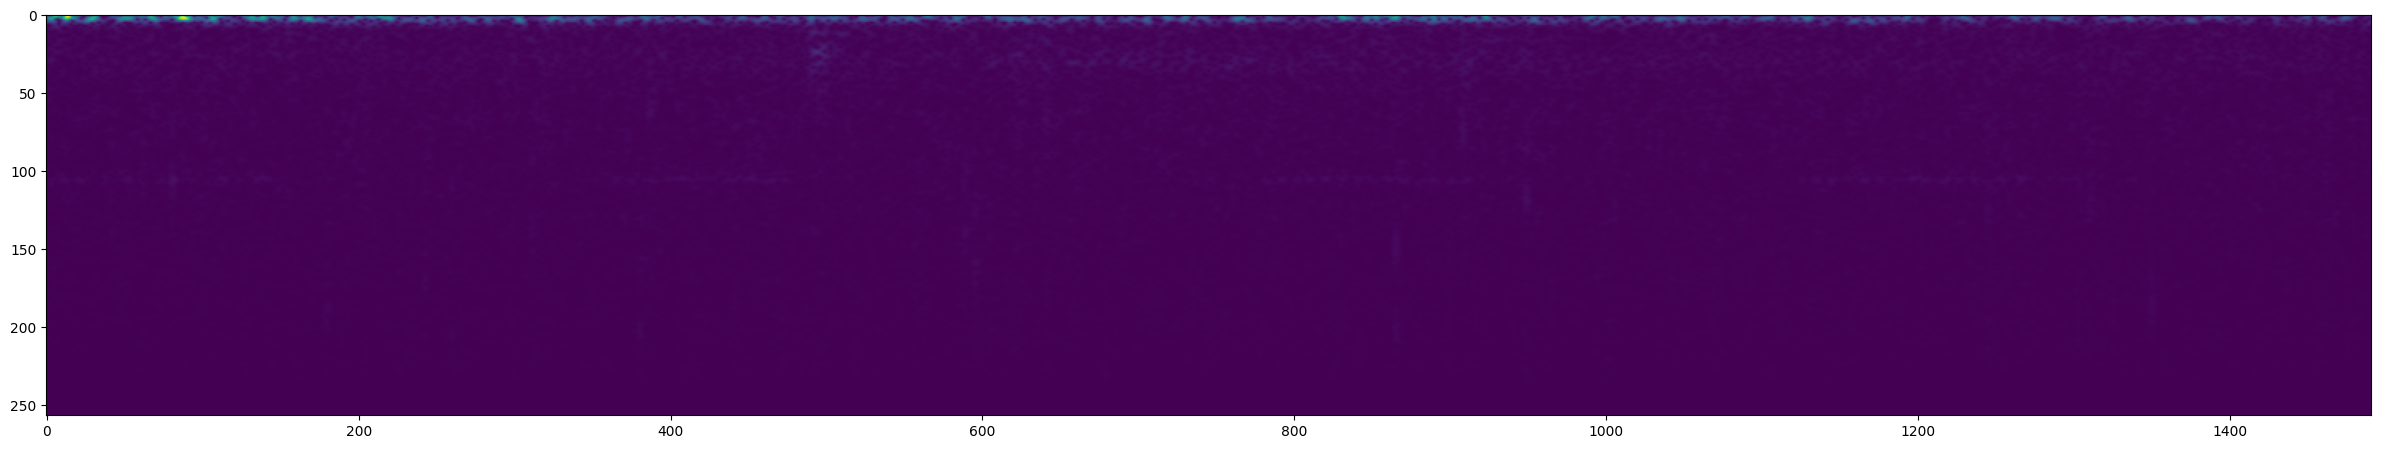

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
data=data.map(preprocess)
data= data.cache()
data= data.shuffle(buffer_size=1000)
data=data.batch(16)
data=data.prefetch(8)

In [ ]:

len(data)

51

In [ ]:
train=data.take(36)
test=data.skip(36).take(15)

In [ ]:
samples ,labels= train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,MaxPool2D
from keras.metrics import Recall,Precision

In [ ]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(1491,257,1)))
model.add(MaxPool2D(3,3))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPool2D(3,3))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile('Adam',loss='BinaryCrossentropy',metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 496, 85, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 494, 83, 16)       2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 164, 27, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 70848)             0         
                                                                 
 dense (Dense)               (None, 128)               9

In [ ]:
history=model.fit(train,epochs=4,validation_data=test)

Epoch 1/4
36/36 [==============================] - 142s 4s/step - loss: 0.7132 - recall: 0.8447 - precision: 0.7473 - val_loss: 0.1513 - val_recall: 0.9844 - val_precision: 0.9545
Epoch 2/4
36/36 [==============================] - 149s 4s/step - loss: 0.1209 - recall: 0.9503 - precision: 0.9503 - val_loss: 0.0501 - val_recall: 0.9394 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 142s 4s/step - loss: 0.0488 - recall: 0.9655 - precision: 0.9929 - val_loss: 0.0257 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 142s 4s/step - loss: 0.0220 - recall: 0.9820 - precision: 0.9939 - val_loss: 0.0054 - val_recall: 1.0000 - val_precision: 1.0000


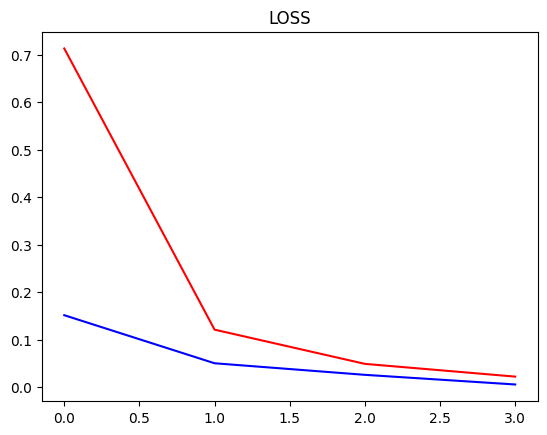

In [ ]:
plt.title('LOSS')
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.show()

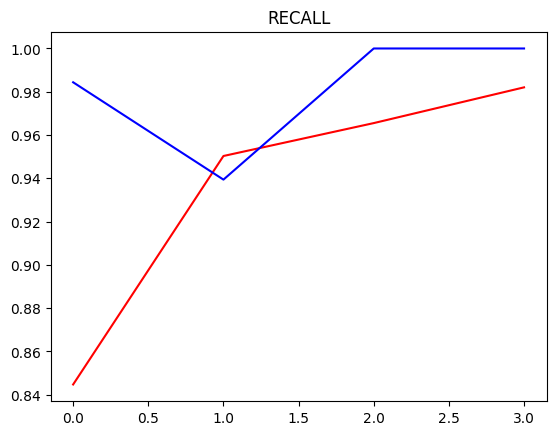

In [ ]:
plt.title('RECALL')
plt.plot(history.history['recall'],'r')
plt.plot(history.history['val_recall'],'b')
plt.show()

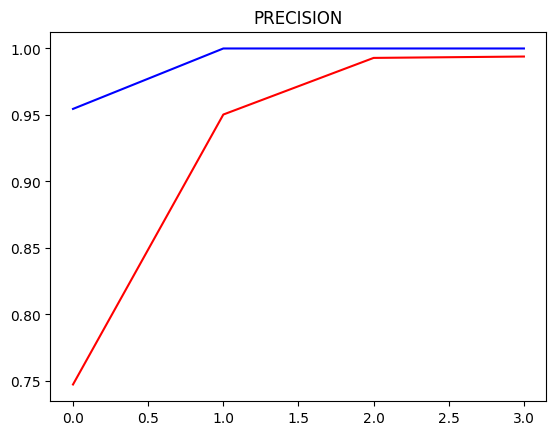

In [ ]:
plt.title('PRECISION')
plt.plot(history.history['precision'],'r')
plt.plot(history.history['val_precision'],'b')
plt.show()

In [ ]:
X_test,Y_test= test.as_numpy_iterator().next()

In [ ]:
X_test.shape

(16, 1491, 257, 1)

In [ ]:
Y_test.shape

(16,)

In [ ]:
Ypred= model.predict(X_test)

1/1 [==============================] - 5s 5s/step


In [ ]:
Ypred

In [ ]:
Ypred=[1 if prediction >0.5 else 0 for prediction in Ypred ]

In [ ]:
Ypred

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [ ]:
tf.math.reduce_sum(Ypred)


<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
tf.math.reduce_sum(Y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [ ]:
Y_test.astype(int)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
def load_mp3_16k_mono(filename):
  res= tfio.audio.AudioIOTensor(filename)
  tensor= res.to_tensor()
  tensor=tf.math.reduce_sum(tensor,axis=1)/2
  sample_rate=res.rate
  sample_rate=tf.cast(sample_rate,dtype=tf.int64)
  wav=tfio.audio.resample(tensor,rate_in=sample_rate,rate_out=16000)
  return wav

In [ ]:
mp3=os.path.join('/content/drive/MyDrive/Forest Recordings/recording_00.mp3')

In [ ]:
wav=load_mp3_16k_mono(mp3)

In [ ]:
audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)

In [ ]:
len(audio_slices)

60

In [ ]:
samples,index=audio_slices.as_numpy_iterator().next()

In [ ]:
samples.shape

(1, 48000)

In [ ]:
def preprocess_mp3(sample,index):
  sample=sample[0]
  zero_padding= tf.zeros([48000]-tf.shape(sample),dtype=tf.float32)
  wav=tf.concat([zero_padding,sample],0)
  spectrogram= tf.signal.stft(wav,frame_length=320,frame_step=32)
  spectrogram=tf.abs(spectrogram)
  spectrogram=tf.expand_dims(spectrogram,axis=2)
  return spectrogram

In [ ]:
audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)

In [ ]:
audio_slices=audio_slices.map(preprocess_mp3)
audio_slices=audio_slices.batch(64)

In [ ]:
ypred=model.predict(audio_slices)
ypred=[1 if prediction >0.5 else 0 for prediction in ypred]

1/1 [==============================] - 9s 9s/step


In [ ]:
len(ypred)

60

In [ ]:
ypred

In [ ]:
from itertools import groupby

In [ ]:
ypred=[key for key ,group in groupby(ypred)]


In [ ]:
ypred

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [ ]:
calls=tf.math.reduce_sum(ypred).numpy()
calls

5

In [ ]:
result={}
for file in os.listdir(os.path.join('/content/drive/MyDrive/Forest Recordings')):
  filepath=os.path.join('/content/drive/MyDrive/Forest Recordings',file)
  wav=load_mp3_16k_mono(filepath)
  audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=48000,sequence_stride=48000,batch_size=1)
  audio_slices=audio_slices.map(preprocess_mp3)
  audio_slices=audio_slices.batch(64)

  ypred=model.predict(audio_slices)
  result[file]=ypred

1/1 [==============================] - 6s 6s/step


In [ ]:
result

In [ ]:
class_pred={}
for file,logits in result.items():
  class_pred[file]= [1 if prediction >0.5 else 0 for prediction in logits]
class_pred

In [ ]:
postprocessed={}
for file,scores in class_pred.items():
  postprocessed[file]=tf.math.reduce_sum([key for key,group in groupby(scores)])
postprocessed

In [ ]:
import csv

In [ ]:
with open('results.csv','w',newline='') as f:
  writer= csv.writer(f,delimiter=';')
  writer.writerow(['recording','capuchin_calls'])
  for key,value in postprocessed.items():
    writer.writerow([key,value])
